In [2]:
import pandas as pd
import gmaps
import matplotlib.pyplot as plt
import json
import requests
from weather_and_gkey import (weather_key, gkey)
import statistics
import warnings
warnings.filterwarnings("ignore")

In [3]:
#importing rankings data 
engrank_df = pd.read_csv("../../team_player/cleaned/engranking.csv")
itrank_df = pd.read_csv("../../team_player/cleaned/itranking.csv")
sprank_df = pd.read_csv("../../team_player/cleaned/spainranking.csv")

In [9]:
#getting the top 4 teams for each of the leagues for these years:
years = [2015, 2016, 2017, 2018, 2019]

#in each of this lists, each index is a dataframe with the top 4 teams in each season
eng_top4teams = []
it_top4teams = []
sp_top4teams = []

#in each of this lists, each index is a dataframe with the last 4 teams in each season
eng_last4teams = []
it_last4teams = []
sp_last4teams = []

for year in years:
    
    #top teams
    eng_top4teams.append(engrank_df.loc[engrank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[:4])
    it_top4teams.append(itrank_df.loc[itrank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[:4])
    sp_top4teams.append(sprank_df.loc[sprank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[:4])
    
    #last 4 teams
    eng_last4teams.append(engrank_df.loc[engrank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[-5:-1])
    it_last4teams.append(itrank_df.loc[itrank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[-5:-1])
    sp_last4teams.append(sprank_df.loc[sprank_df["Year"]==year][['Year','Teams','Points']].sort_values('Points', ascending = False).iloc[-5:-1])

In [6]:
'''
Accessing all players data files
Each index in places [0:4] is a dataframe with the players data for 2015, 2016, 2017, 2018, 2019

'''

numbers = [15,16,17,18, 19]
players = []

for number in numbers:
    players.append(pd.read_csv(f"../../team_player/raw/players_{number}.csv"))



In [63]:
#chanche names function so that I can match the team names from rankins.csv with players csv

def names_change(df):
    
    #italian league
    df["club"] = df["club"].str.replace("Lazio", "SS Lazio")
    df["club"] = df["club"].str.replace("Roma", "AS Roma")
    df['club'] = df['club'].str.replace("Inter", "FC Internazionale Milano")
    df["club"] = df["club"].str.replace("FC Crotone", "Crotone")
    
    df["club"] = df["club"].str.replace("Fiorentina", "ACF Fiorentina")
    df["club"] = df["club"].str.replace("Sassuolo", "Sassuolo Calcio")
    df["club"] = df["club"].str.replace("Chievo Verona", "AC Chievo Verona")
    df["club"] = df["club"].str.replace("Cagliari", "Cagliari Calcio")
    
    #spanish league
    df["club"] = df["club"].str.replace("Real Sporting de Gijón", "Sporting Gijón")
    df["club"] = df["club"].str.replace("Athletic Club de Bilbao", "Athletic Club Bilbao")
    df["club"] = df["club"].str.replace("Deportivo de La Coruña", "RCD La Coruña")
    df["club"] = df["club"].str.replace("RC Celta", "RC Celta Vigo")
    
    return df

#apply function to all players dataframes
for players_df in players:
    names_change(players_df)

In [12]:
#function for getting nationatilities per season

def get_nationalities(league_topteams, players):
    
    '''
    This function takes two list of dataframes. Each index of the list is a dataframe for 1 season for 5 seasons
    
        index 0 = 2015
        .
        .
        index 4 = 2019
    
    and returns a list of dataframes with the players names, ages, nationalities and teams for each season
    
    '''
    
    #empty list: preparing to append a dataframe for each season
    all_seasons_data =[]
    
    #iterating through both dataframes at once: each iteration is a season
    for topteams, season_players in zip(league_topteams, players):
    
        nationalities_1_season = []
        for index, row in topteams.iterrows():
            team = row['Teams']
        
            #getting relevant player data for 1/4 teams: each iteration is 1 team for that season
            nationalities_1_team = season_players[season_players['club']== team][['short_name','age', 'nationality','club']].reset_index()
            nationalities_1_season.append(nationalities_1_team)
            
        #packing all 1 season teams player data into 1 dataframe and appending to all_seasons
        new_df = pd.concat(nationalities_1_season)
        
        all_seasons_data.append(new_df.drop('index', axis = 1))
        
    return all_seasons_data
    

In [13]:
'''
Each of league_nationalities_top_teams is a list of dataframes with players and nationalities for each of the top4  teams
and each index represents a differents season

'''
engleague_nationalities_top_teams = get_nationalities(eng_top4teams, players)
itleague_nationalities_top_teams = get_nationalities(it_top4teams, players)
spleague_nationalities_top_teams = get_nationalities(sp_top4teams, players)


In [53]:
engleague_nationalities_last_teams = get_nationalities(eng_last4teams, players)
itleague_nationalities_last_teams = get_nationalities(it_last4teams, players)
spleague_nationalities_last_teams = get_nationalities(sp_last4teams, players)

## This section is an analysis on nationalities  at a league level: combining data for the top 4 teams in each season across 2015 - 2019 for each league

In [15]:
def league_all_seasons_nationalities(league_nationalities_top_teams, local_nationality):
    
    '''
    This function takes a list of dataframes for a league of choice, and the local nationality for that league as a string. 
    Each index for the first parameter is a different season, and the data corresponds to the top 4 teams in each season. 
    It concats all dataframes into one single dataframe and returns a nationality count for that leagues top teams accross 
    2015-2019 normalised based on local_nationality.
    
    '''
    #concatinating all list indexes in to dataframe: 2015 - 2019 all in one dataframe
    all_seasons = pd.concat(league_nationalities_top_teams).drop_duplicates(subset = 'short_name')
    
    #getting nationality count
    season_nationalities = all_seasons.groupby('nationality').count().sort_values('short_name',ascending = False)
    tidy_up = season_nationalities.reset_index()[['nationality','short_name']].rename({'short_name': 'count'}, axis = 1)
    
    #getting local nationality count
    local_count = tidy_up[tidy_up['nationality'] == local_nationality]['count'].astype(float)[0]
    
    #normalising data based on local_nationality
    tidy_up['count'] = round(tidy_up['count'] / local_count * 100, 3)
    
    #chanching count to percentages
    tidy_up = tidy_up.rename({'count' : 'percentage'}, axis = 1)
    
    return tidy_up

In [16]:
#all 5 seasons normalised nationalities data for each season's top 4 teams: 1 dataframe of nationalities frequencies
engleague_all_seasons_nationalities = league_all_seasons_nationalities(engleague_nationalities_top_teams, 'England')
itleague_all_seasons_nationalities = league_all_seasons_nationalities(itleague_nationalities_top_teams, 'Italy')
spleague_all_seasons_nationalities = league_all_seasons_nationalities(spleague_nationalities_top_teams, 'Spain')

In [11]:
#Not using as we are not plotting this data in GMAPS
#all 5 seasons normalised nationalities data for each season's last 4 teams: 1 dataframe of nationalities frequencies
#last4_engleague_all_seasons_nationalities = league_all_seasons_nationalities(engleague_nationalities_last_teams, 'England')
#last4_itleague_all_seasons_nationalities = league_all_seasons_nationalities(itleague_nationalities_last_teams, 'Italy')
#last4_spleague_all_seasons_nationalities = league_all_seasons_nationalities(spleague_nationalities_last_teams, 'Spain')

In [12]:
#creating exports for the top teams
engleague_all_seasons_nationalities.to_csv("../cleaned/english_nationalities_all_seasons.csv")
itleague_all_seasons_nationalities.to_csv("../cleaned/italy_nationalities_all_seasons.csv")
spleague_all_seasons_nationalities.to_csv("../cleaned/spain_nationalities_all_seasons.csv")

In [17]:
#loading json with countries and their capital cities 
with open('country_by_capital.json' , 'r') as jsonfile:
    data = jsonfile.read()
country_capitals = json.loads(data)
#print(json.dumps(country_capitals, indent = 4, sort_keys = True))

#creating a dataframe for countries and nationalities
countries = []
cities = []

for i in range(len(country_capitals)):
    
    #getting inside each dictionary
    for key, value in country_capitals[i].items():
        
        if key == 'country':
            countries.append(value)
        
        if key == "city":
            cities.append(value)
        
countries_and_capitals_df = pd.DataFrame({
    'nationality': countries,
    'capital':cities
})

countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Bruxelles [Brussel]', 'Brussel')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('San Jos', 'San Jose')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Santaf', 'Bogota')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Bucuresti', 'Bucharest')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Yaound', 'Yaounde')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Athenai', 'Athens')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Asunci', 'Asuncion')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Helsinki [Helsingfors]', 'Helsinki')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Ciudad de M', 'Mexico City')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Roma', 'Rome')
countries_and_capitals_df['capital'] = countries_and_capitals_df['capital'].replace('Bras', 'Brasilia')


In [19]:
def get_coordinates(league_all_seasons_nationalities):
    
    '''
    Takes as a parameter a dataframe of nationalities, and returns a dataframe with capital cities and their corresponding
    latitudes and longitudes by making API calls to Openweathermap
    
    '''
    
    #merging on 
    league_and_locations = pd.merge(league_all_seasons_nationalities, countries_and_capitals_df, on = 'nationality', how = 'inner')

    league_and_locations['lat'] = ''
    league_and_locations['lng'] = ''

    for index, row in league_and_locations.iterrows():
    
        city = row['capital']
    
        try: 
            url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_key}"
            response = requests.get(url).json()
        
            #lat and longitude
            league_and_locations['lat'].iloc[index] = response['coord']['lat']
            league_and_locations['lng'].iloc[index] = response['coord']['lon']
        
        except:
            print(f"Name issue:{city} at index:{index}")
        

    return league_and_locations

In [20]:
#API Call to weathermap 
engleague_coordinates = get_coordinates(engleague_all_seasons_nationalities)

In [21]:
#API Call to weather map
itleague_coordinates = get_coordinates(itleague_all_seasons_nationalities)

In [22]:
#API call to weather map
spleague_coordinates = get_coordinates(spleague_all_seasons_nationalities)

In [23]:
itleague_coordinates['lat'] = itleague_coordinates['lat'].replace(34.26, 41.902782)
itleague_coordinates['lng'] = itleague_coordinates['lng'].replace(-85.16, 12.496366)
engleague_coordinates['lat'] = engleague_coordinates['lat'].replace(34.26, 41.902782)
engleague_coordinates['lng'] = engleague_coordinates['lng'].replace(-85.16, 12.496366)
spleague_coordinates['lat'] = spleague_coordinates['lat'].replace(34.26, 41.902782)
spleague_coordinates['lng'] = spleague_coordinates['lng'].replace(-85.16, 12.496366)

In [26]:
def heatmap_plot(league_coordinates):
    
    # Configure gmaps with API key
    gmaps.configure(api_key=gkey)
    
    # Heatmap layer
    fig = gmaps.figure()

    league_coordinates['lat'] = league_coordinates['lat'].astype(float)
    league_coordinates['lng'] = league_coordinates['lng'].astype(float)

    #coordinates
    locations = league_coordinates[['lat', 'lng']]
    
    #nationality frequency as weight parameter
    weight = league_coordinates['percentage'].astype(float)*10
    
    heat_layer = gmaps.heatmap_layer(locations, weights = weight, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 2)
    
    #add layer
    fig.add_layer(heat_layer)
    
    #center
    gmaps.figure(center=(0, 0), zoom_level=1)

    return fig

In [27]:
heatmap_plot(engleague_coordinates)

Figure(layout=FigureLayout(height='420px'))

In [28]:
heatmap_plot(itleague_coordinates)

Figure(layout=FigureLayout(height='420px'))

In [29]:
heatmap_plot(spleague_coordinates)

Figure(layout=FigureLayout(height='420px'))

## The following is a ethnic diversity analysis at a teams level  for the top 4 and last 4 teams of each league for every season

In [67]:
def league_diversity_per_teams(league_nationalities, league_top4teams, local_country):
    
    '''
    This function takes as an input a list of dataframes with players nationalities and each league top 4 teams
    and returns a dictionaty where each key is a season (2015..2019) and each value pair is dictionaries with 
    the teams as keys and their diversity count as value pairs.
    
    '''
    
    #number of players
    #number_players = 33
    
    #diversity in each team english league 2015
    years = [2015, 2016, 2017, 2018, 2019]

    #empty dictionary of dictionaries: each year will be a key for a dictionary of the players diversity count
    all_seasons_diversity = {}

    season_count = 0
    for year in years:
    
        #empty dictionary for the team
        team_percentage_local_players_1_season = {} 
        for index, row in league_top4teams[season_count].reset_index().iterrows():
            
            #defininf team name from dataframe
            team = row['Teams']
            
            #diversity = count of different nationalities in each team
            team_player_count = len(league_nationalities[season_count][(league_nationalities[season_count]['club'] == team)])
            
            
            national_player_count = len(league_nationalities[season_count][
                (league_nationalities[season_count]['club'] == team) & (
                    league_nationalities[season_count]['nationality'] == local_country)])
            
            try:
                team_percentage_local_players_1_season[team] = round(national_player_count / team_player_count * 100, 1)
            
            except Exception as ex:
                #print(f"There was an issue with {team} in season {season_count}")
                #print(ex)
                continue
                
        #creating dictionary per season: key is the season ; value_pair: nested dictionary of teams and their diversity
        all_seasons_diversity[year] = team_percentage_local_players_1_season
    
        #next season
        season_count += 1

    return all_seasons_diversity

In [31]:
def average_diversity(league_nationalities, teams, country):
    
    '''
    This function calculates the average diversity across all seasons [2015:2019]
    
    '''
    
    values = []
    for season in league_diversity_per_teams(league_nationalities, teams, country).keys():
        teams_dict = league_diversity_per_teams(league_nationalities, teams, country)[season]
        for team, percent in teams_dict.items():
            values.append(percent)
    return statistics.mean(values) 

In [32]:
#eng top
average_diversity(engleague_nationalities_top_teams, eng_top4teams, 'England')

36.005

In [33]:
#eng last
average_diversity(engleague_nationalities_last_teams, eng_last4teams, 'England')

42.095

In [34]:
#IT top
average_diversity(itleague_nationalities_top_teams, it_top4teams, 'Italy')

34.975

In [35]:
#IT last
average_diversity(itleague_nationalities_last_teams, it_last4teams, 'Italy')

64.28947368421052

In [36]:
#spain top
average_diversity(spleague_nationalities_top_teams, sp_top4teams, 'Spain')

47.615

In [37]:
#spain last
average_diversity(spleague_nationalities_last_teams, sp_last4teams, 'Spain')

70.16

*******************************************************************************************************************************

In [40]:
def plot_diversity_by_teams(league_nationalities, league_top4teams, local_country):
    
    '''
    This function takes two list of dataframe and returns a plot with the diversity count for each league top teams. 
    This function calls another function: league_diversity, whose output is a dictionary of dictionaries with the top
    teams for each season and their diversity count
    
    '''
    %matplotlib inline
    
    plt.figure(figsize = [17.5,4])

    #subplot counter
    subplot_count = 1
        
    #looping over league_diversity function whose output is a dictionary of dictionaries
    for year, teams_diversity_count in league_diversity_per_teams(league_nationalities, league_top4teams, local_country).items():
        
        tick_location = [1, 2, 3, 4]      
        frequencies = [diversity_count for team, diversity_count in teams_diversity_count.items()]
        
        #plotting
        plt.subplot(1,5,subplot_count)
        plt.bar(tick_location, frequencies)
        plt.title(f"% of local players for {year}")
        plt.xticks(tick_location, [team for team in teams_diversity_count.keys()], rotation = 90)
        
        # counter
        subplot_count += 1
        
        

In [66]:
def plot_diversity_last4_teams(league_nationalities, league_top4teams, local_country):
    
    '''
   This is the same function as the previous one but the output is a different colour grapgh
    
    '''
    %matplotlib inline
    
    plt.figure(figsize = [17.5,4])

    #subplot counter
    subplot_count = 1
        
    #looping over league_diversity function whose output is a dictionary of dictionaries
    for year, teams_diversity_count in league_diversity_per_teams(league_nationalities, league_top4teams, local_country).items():
        
        tick_location = [1, 2, 3, 4]      
        frequencies = [diversity_count for team, diversity_count in teams_diversity_count.items()]
        
        #plotting
        plt.subplot(1,5,subplot_count)
        plt.bar(tick_location, frequencies, color = 'orange')
        plt.title(f"% of local players for {year}")
        plt.xticks(tick_location, [team for team in teams_diversity_count.keys()], rotation = 90)
        
        # counter
        subplot_count += 1
        

In [68]:
league_diversity_per_teams(itleague_nationalities_last_teams, it_last4teams, 'Italy')

{2015: {'Palermo': 36.7, 'Carpi': 75.0, 'Frosinone': 88.5},
 2016: {'Genoa': 27.6, 'Empoli': 56.0, 'Palermo': 48.1},
 2017: {'Bologna': 45.2, 'SPAL': 100.0, 'Hellas Verona': 79.2},
 2018: {'Parma': 86.7, 'Genoa': 40.7, 'Empoli': 58.6, 'Frosinone': 87.5},
 2019: {'Torino': 46.2, 'Genoa': 32.0, 'Lecce': 89.7, 'Brescia': 80.0}}

In [65]:
it_last4teams[0]

Year           Teams  Points
7   2015         Palermo      39
19  2015  Udinese Calcio      39
13  2015           Carpi      38
4   2015       Frosinone      31

                            *** English League: Premiere League's Top 4 vs Last 4 in each season ****

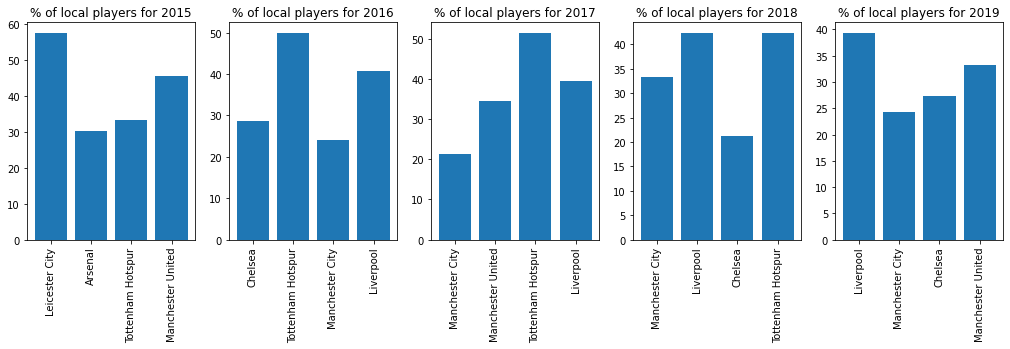

In [42]:
plot_diversity_by_teams(engleague_nationalities_top_teams, eng_top4teams, 'England')

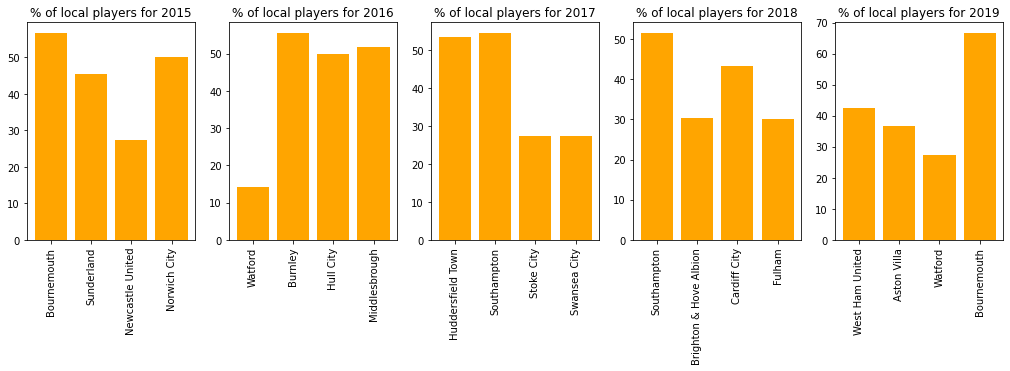

In [43]:
plot_diversity_last4_teams(engleague_nationalities_last_teams, eng_last4teams, 'England')

                            *** Italian: Serie A's League: Top 4 vs Last 4 in each season ****

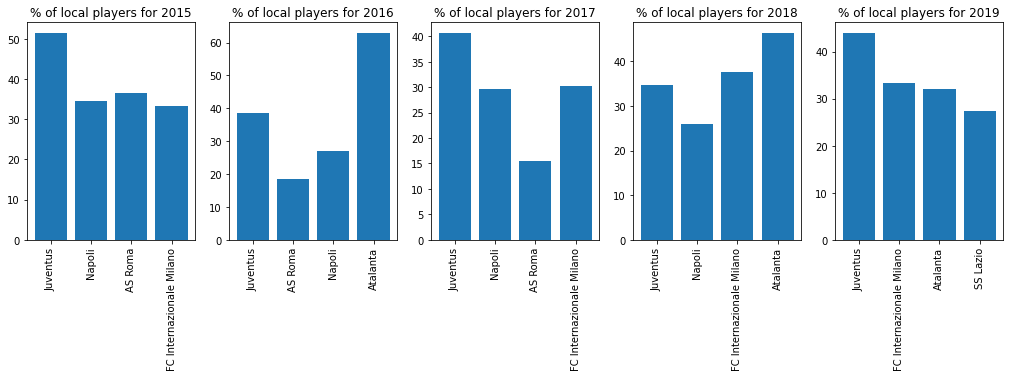

In [44]:
plot_diversity_by_teams(itleague_nationalities_top_teams, it_top4teams, 'Italy')

In [ ]:
#getting an error
plot_diversity_last4_teams(itleague_nationalities_last_teams, it_last4teams, 'Italy')

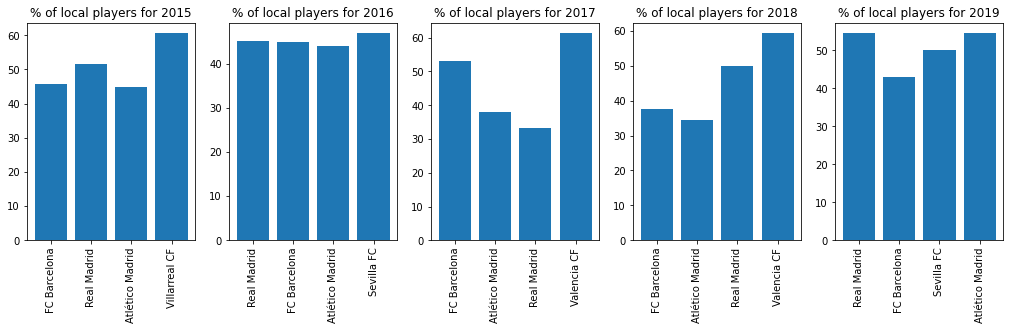

In [46]:
plot_diversity_by_teams(spleague_nationalities_top_teams, sp_top4teams, 'Spain')

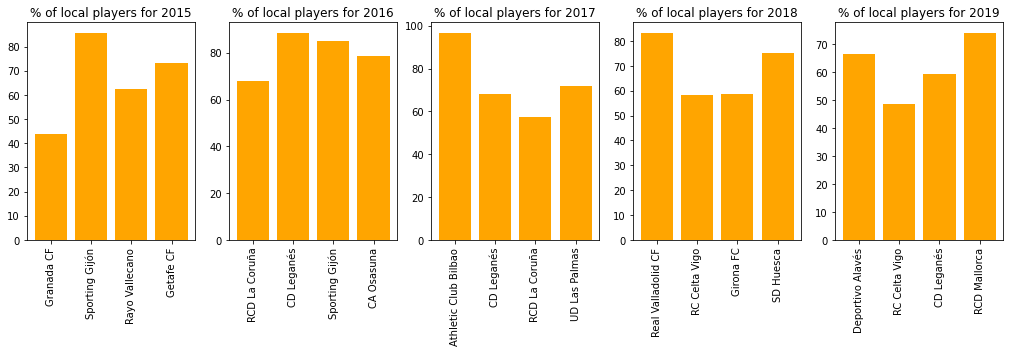

In [47]:
plot_diversity_last4_teams(spleague_nationalities_last_teams, sp_last4teams, 'Spain')